In [1]:
!pip install -q pycaret

In [2]:
!pip install -q catboost

In [3]:
!pip install optuna

In [4]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import optuna

In [5]:
# The paradigm for project
# 1. cleaning the data e.g like missing values, data types, etc.
# 2. feature engineering
# 3. feature transformation
# 4. Encoding
# 5. Scaling
# 6. target transformation
# 7. model selection
# 8. Hyperparameter optimization
# 9. Ensembling
# 4. feature selection After training the models.

# Combining train and test datasets. 


In [6]:
# Import the datasets

train = pd.read_csv(r"train.csv")
test = pd.read_csv(r"test.csv")
sample_submission = pd.read_csv(r"sample_submission.csv")

In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
target = train["SalePrice"]
test_ids = test['Id']

train = train.drop(columns=["Id", "SalePrice"], axis=1)
test = test.drop(columns=["Id"], axis=1)

data1 = pd.concat([train, test], axis=0).reset_index(drop=True)
data1

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Un

In [9]:
target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

# Cleaning

In [10]:
data2 = data1.copy()

### Checking and correcting the data types

In [11]:
data2['MSSubClass'] = data2['MSSubClass'].astype(str)

### Filling the categorical missing values using constant imputation method and using column mode

In [12]:
# Impute using a constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data2[column] = data2[column].fillna("None")

# Impute using the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data2[column] = data2[column].fillna(data2[column].mode()[0])

In [13]:
data3 = data2.copy()

### Filling the numerical missing values using KNN to replace using the nearest neighbors

In [14]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [15]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data3 = knn_impute(data3, column)

In [16]:
data4 = data3.copy()

# Feature Engineering 

In [17]:
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [18]:
data5 = data4.copy()

# Feature Transformation 

### Log Transformation for Skewed Features

In [19]:
skew_df = pd.DataFrame(data5.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data5[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [20]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data5[column] = np.log1p(data5[column])

### Cosine Transformation for Cyclical Features

In [21]:
# To have all the in weather form 1 & 12 are cold while the middle numbers are hot like summer and winter
data4['MoSold'] = (-np.cos(0.5236 * data5['MoSold']))

In [22]:
data6 = data5.copy()

# Encode Categoricals

#### Since ML models does not understand letters, I converted all the categorical variables to dummies. This can also be done using OneHotEncoder OHE

In [23]:
data6 = pd.get_dummies(data6)

In [24]:
data7 = data6.copy()

# Scaling

#### This will be done using standardscaler

In [25]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

In [26]:
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [27]:
data8 = data7.copy()

# Target Transformation

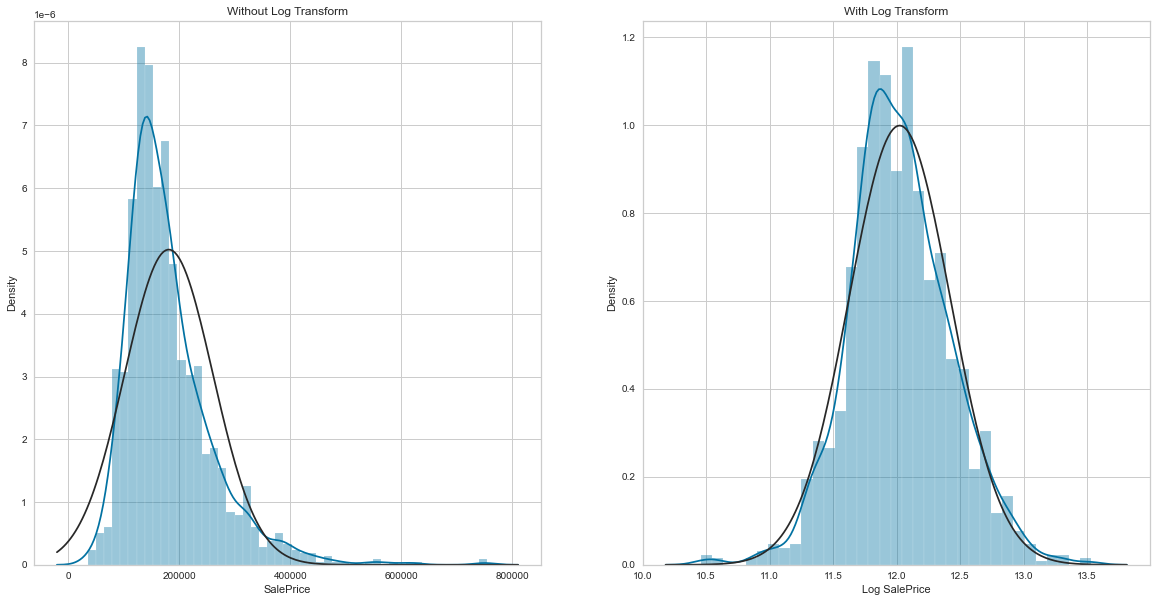

In [28]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [29]:
log_target = np.log(target)

In [30]:
np.exp(log_target) # To  get back the actual values of the target

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

# Split the Data

#### The data is splitted into training and testing respectively for ml 

In [31]:
train_dt = data8.loc[:train.index.max(), :].copy()
test_dt = data8.loc[train.index.max() + 1:, :].reset_index(drop=True).copy()

In [32]:
train_dt

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

In [33]:
test_dt

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SqFtPerRoom,Total_Home_Quality,Total_Bathrooms,HighQualSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functio

# Model Selection

In [34]:
#setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

# Hyperparameter Optimization

In [35]:
# def br_objective(trial):
#     n_iter = trial.suggest_int('n_iter', 50, 600)
#     tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
#     alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
#     alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
#     lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
#     lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    
#     model = BayesianRidge(
#         n_iter=n_iter,
#         tol=tol,
#         alpha_1=alpha_1,
#         alpha_2=alpha_2,
#         lambda_1=lambda_1,
#         lambda_2=lambda_2
#     )
    
#     model.fit(train_final, log_target)
    
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    
#     return np.mean(cv_scores)

# Bagging Ensemble

In [36]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

In [37]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [38]:
for name, model in models.items():
    model.fit(train_dt, log_target)
    print(name + " trained.")

catboost trained.
br trained.
lightgbm trained.
ridge trained.
omp trained.


# Evaluation

In [39]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_dt, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [40]:
results

{'catboost': array([1.12060611, 1.09790685, 1.10712748, 1.158875  , 1.15227004,
        1.10776087, 1.12258794, 1.10048371, 1.12381555, 1.1327321 ]),
 'br': array([1.1236938 , 1.10465562, 1.12405625, 1.16848   , 1.1524003 ,
        1.12873658, 1.12522895, 1.10275044, 1.18802719, 1.13298601]),
 'lightgbm': array([1.12957546, 1.10531072, 1.11204297, 1.16955427, 1.16737513,
        1.11324252, 1.12723476, 1.10936854, 1.14745815, 1.14223858]),
 'ridge': array([1.12338036, 1.1053367 , 1.12412145, 1.16994036, 1.15545706,
        1.12173273, 1.1260853 , 1.1037994 , 1.18188318, 1.13358299]),
 'omp': array([1.13163194, 1.10136166, 1.12704954, 1.18074775, 1.16256399,
        1.17119603, 1.12960897, 1.12360152, 1.1832052 , 1.15073542])}

In [41]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

----------
catboost
1.122416565605037
0.019653099866795948
----------
br
1.1351015144106285
0.025656641991269685
----------
lightgbm
1.1323401113019387
0.022377581009135113
----------
ridge
1.1345319533871139
0.02489861334742039
----------
omp
1.1461702025542813
0.026175319620290106


In [42]:
final_pred = (
    0.4 * np.exp(models['catboost'].predict(test_dt)) +
    0.2 * np.exp(models['br'].predict(test_dt)) +
    0.2 * np.exp(models['lightgbm'].predict(test_dt)) +
    0.1 * np.exp(models['ridge'].predict(test_dt)) +
    0.1 * np.exp(models['omp'].predict(test_dt))
)

In [43]:
final_pred

array([122493.50352788, 157853.3011217 , 181487.16753948, ...,
       161328.7581812 , 116044.14662156, 220079.53848974])

# Model for submission

In [44]:
submission = pd.concat([test_ids, pd.Series(final_pred, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,122493.503528
1,1462,157853.301122
2,1463,181487.167539
3,1464,192790.547749
4,1465,191652.862230
...,...,...
1454,2915,85947.809939
1455,2916,81560.338127
1456,2917,161328.758181
1457,2918,116044.146622


In [45]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659
